##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 전문가를 위한 TensorFlow 2 빠른 시작

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이것은 [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) 노트북 파일입니다. Python 프로그램은 브라우저에서 직접 실행되므로 TensorFlow를 배우고 사용하기에 좋습니다. 이 튜토리얼을 따르려면 이 페이지 상단에 있는 버튼을 클릭하여 Google Colab에서 노트북을 실행하세요.

1. 파이썬 런타임(runtime)에 연결하세요: 메뉴 막대의 오른쪽 상단에서 *CONNECT*를 선택하세요.
2. 노트북의 모든 코드 셀(cell)을 실행하세요: *Runtime* &gt; *Run all*을 선택하세요.

TensorFlow 2를 다운로드하여 설치합니다. TensorFlow를 프로그램으로 가져옵니다.

참고: TensorFlow 2 패키지를 설치하려면 `pip`를 업그레이드하세요. 자세한 내용은 [설치 가이드](https://www.tensorflow.org/install)를 참조하세요.

TensorFlow를 프로그램으로 가져옵니다.

In [4]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

[MNIST 데이터셋](http://yann.lecun.com/exdb/mnist/)을 로드하여 준비합니다.

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


tf.data를 사용하여 데이터셋을 섞고 배치를 만듭니다:

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

케라스(Keras)의 [모델 서브클래싱(subclassing) API](https://www.tensorflow.org/guide/keras#model_subclassing)를 사용하여 `tf.keras` 모델을 만듭니다:

In [9]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

훈련에 필요한 옵티마이저(optimizer)와 손실 함수를 선택합니다: 

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

모델의 손실과 성능을 측정할 지표를 선택합니다. 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

`tf.GradientTape`를 사용하여 모델을 훈련합니다:

In [12]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

이제 모델을 테스트합니다:

In [13]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [14]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
        )

Epoch 1, Loss: 0.1348547339439392, Accuracy: 95.90499877929688, Test Loss: 0.06194254755973816, Test Accuracy: 97.87999725341797
Epoch 2, Loss: 0.04449133202433586, Accuracy: 98.67832946777344, Test Loss: 0.05704420804977417, Test Accuracy: 98.15999603271484


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-50b7bbc0271c>", line 11, in <module>
    train_step(images, labels)
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 3040, in __call__
    filtered_flat_args, captured_inputs=graph_function.captured_inputs)  # pylint: disable=protected-access
  File "/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/pyt

TypeError: object of type 'NoneType' has no len()

훈련된 이미지 분류기는 이 데이터셋에서 약 98%의 정확도를 달성합니다. 더 자세한 내용은 [TensorFlow 튜토리얼](https://www.tensorflow.org/tutorials/)을 참고하세요.

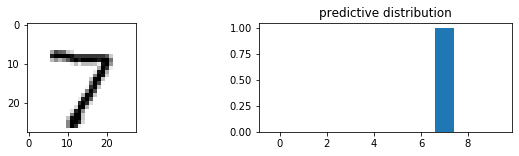

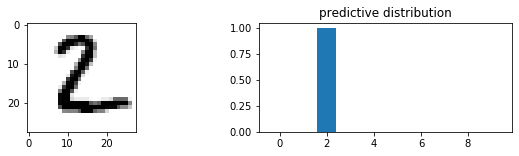

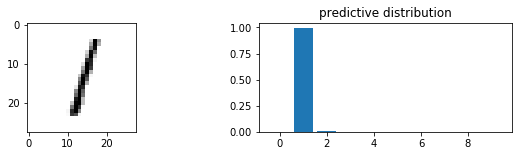

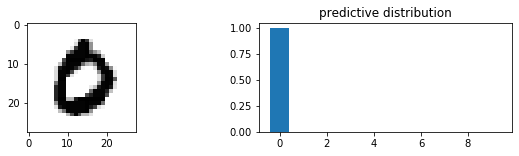

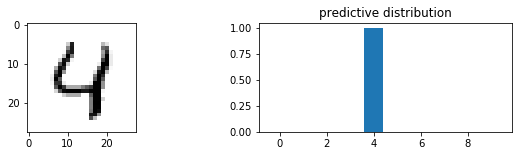

In [32]:
import matplotlib.pyplot as plt

for test_images, test_labels in test_ds:
    prediction = model(test_images, training=False)
    prediction = tf.nn.softmax(prediction)
    for i in range(5):
        image = test_images[i, :, :, 0]
        plt.figure(figsize=[10, 2])
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.subplot(1, 2, 2)
        plt.title('predictive distribution')
        plt.bar(range(10), prediction[i])
        plt.show()
    break